In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2025-10-21 08:42:29--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.27.124, 3.5.28.119, 54.231.137.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.27.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G   109MB/s    in 3m 36s  

2025-10-21 08:46:05 (85.5 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [3]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2025-10-21 08:51:01--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.21.112, 3.5.11.188, 16.15.179.107, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.21.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M   112MB/s    in 9.6s    

2025-10-21 08:51:11 (80.8 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [4]:
!wget http://images.cocodataset.org/zips/test2017.zip

--2025-10-21 08:51:13--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.32.97, 52.216.213.249, 52.216.94.155, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.32.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  92.7MB/s    in 75s     

2025-10-21 08:52:28 (84.5 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



In [5]:
# Extract them
!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q test2017.zip

In [6]:
!ls -la

total 5612
drwxr-xr-x 1 root root    4096 Oct 21 08:59 .
drwxr-xr-x 1 root root    4096 Oct 21 08:33 ..
drwxr-xr-x 4 root root    4096 Oct 17 22:29 .config
drwx------ 5 root root    4096 Oct 21 08:36 drive
drwxr-xr-x 2 root root    4096 Oct 21 08:58 .ipynb_checkpoints
drwxr-xr-x 1 root root    4096 Oct 17 22:29 sample_data
drwxrwxr-x 2 root root 1392640 Aug 31  2017 test2017
drwxrwxr-x 2 root root 4136960 Aug 31  2017 train2017
drwxrwxr-x 2 root root  180224 Aug 31  2017 val2017


In [7]:
import h5py
import numpy as np
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split



# # Create output directories in Drive
# output_base = '/content/drive/MyDrive/coco_colorization'
# os.makedirs(f'{output_base}/train', exist_ok=True)
# os.makedirs(f'{output_base}/val', exist_ok=True)
# os.makedirs(f'{output_base}/test', exist_ok=True)

# print("Output directories created!")

In [ ]:
# def process_image(image_path, target_size=(256, 256)):
#     """
#     Process a single image:
#     1. Load and resize to 256x256
#     2. Convert RGB to LAB
#     3. Normalize channels
#     """
#     try:
#         # Load image
#         img = cv2.imread(image_path)
#         if img is None:
#             return None

#         # Convert BGR to RGB (OpenCV loads as BGR)
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Resize to 256x256
#         img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)

#         # Convert RGB to LAB
#         img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)

#         # Normalize:
#         # L channel: 0-100 → 0-1
#         # A/B channels: 0-255 → -1 to 1
#         img_normalized = img_lab.astype(np.float32)
#         img_normalized[..., 0] = img_normalized[..., 0] / 100.0        # L: 0-1
#         img_normalized[..., 1] = (img_normalized[..., 1] - 128.0) / 128.0  # A: -1 to 1
#         img_normalized[..., 2] = (img_normalized[..., 2] - 128.0) / 128.0  # B: -1 to 1

#         return img_normalized

#     except Exception as e:
#         print(f"Error processing {image_path}: {e}")
#         return None

In [8]:
def process_image_corrected(image_path, target_size=(128, 128)):
    """
    CORRECTED version - uses proper LAB ranges
    """
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to 256x256 (128x128)
        img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_AREA)

        # Convert RGB to LAB
        img_lab = cv2.cvtColor(img_resized, cv2.COLOR_RGB2LAB)

        # CORRECT Normalization:
        img_normalized = img_lab.astype(np.float32)
        img_normalized[..., 0] = img_normalized[..., 0] / 255.0        # L: 0-255 → 0-1
        img_normalized[..., 1] = (img_normalized[..., 1] - 128.0) / 128.0  # A: -1 to 1
        img_normalized[..., 2] = (img_normalized[..., 2] - 128.0) / 128.0  # B: -1 to 1

        return img_normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [ ]:
# def process_and_save_batch(image_paths, output_dir, batch_name, batch_size=1000):
#     """
#     Process images in batches and save as .npy files
#     """
#     processed_data = []

#     for i, img_path in enumerate(tqdm(image_paths, desc=f"Processing {batch_name}")):
#         processed_img = process_image(img_path)

#         if processed_img is not None:
#             processed_data.append(processed_img)

#         # Save batch periodically to manage memory
#         if len(processed_data) >= batch_size:
#             batch_path = f"{output_dir}/{batch_name}_batch_{i//batch_size}.npy"
#             np.save(batch_path, np.array(processed_data))
#             print(f"Saved {len(processed_data)} images to {batch_path}")
#             processed_data = []  # Clear memory

#     # Save remaining images
#     if processed_data:
#         batch_path = f"{output_dir}/{batch_name}_batch_final.npy"
#         np.save(batch_path, np.array(processed_data))
#         print(f"Saved final batch of {len(processed_data)} images to {batch_path}")

#     return len(processed_data)

In [ ]:
!pip install h5py

In [ ]:
os.makedirs('/content/drive/MyDrive/coco_colorization_hdf5', exist_ok=True)

In [9]:
def process_and_save_hdf5_optimized(image_paths, output_path, split_name, max_images=None):
    """
    Optimal solution: HDF5 + float16 + compression
    Expected size: 12-18GB for entire dataset
    """
    if max_images:
        image_paths = image_paths[:max_images]

    # Process first image to get shape
    sample = process_image_corrected(image_paths[0])
    if sample is None:
        # Try another image if first fails
        for img_path in image_paths[1:10]:
            sample = process_image_corrected(img_path)
            if sample is not None:
                break
        if sample is None:
            raise ValueError("Could not process any sample images")

    with h5py.File(output_path, 'w') as f:
        # Create resizable dataset
        images_dset = f.create_dataset(
            'images',
            shape=(0, 128, 128, 3),
            maxshape=(None, 128, 128, 3),
            dtype=np.float16,
            compression='gzip',
            compression_opts=9,
            chunks=(500, 128, 128, 3)  # Increased chunk size for better performance
        )

        batch = []
        batch_size = 2000  # Increased from 500 to 2000 - much faster!
        success_count = 0

        for i, img_path in enumerate(tqdm(image_paths, desc=f"Processing {split_name}")):
            processed_img = process_image_corrected(img_path)
            if processed_img is not None:
                # Convert to float16 for storage efficiency
                batch.append(processed_img.astype(np.float16))
                success_count += 1

            # Save in batches to manage memory
            if len(batch) >= batch_size or i == len(image_paths) - 1:
                if batch:
                    # Resize dataset
                    current_size = images_dset.shape[0]
                    new_size = current_size + len(batch)
                    images_dset.resize(new_size, axis=0)

                    # Add batch
                    images_dset[current_size:new_size] = np.array(batch)
                    print(f"💾 Saved batch of {len(batch)} images (total: {new_size})")
                    batch = []  # Clear batch

        print(f"✅ Completed {split_name}: {success_count}/{len(image_paths)} images processed")
        print(f"📊 Final dataset shape: {images_dset.shape}")
        print(f"💾 File size: {os.path.getsize(output_path) / (1024**3):.2f} GB")

    return success_count

In [10]:
# Get all image paths
def get_image_paths(directory):
    """Get all image file paths from directory"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_paths = []

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

# Get image paths from each split
train_paths = get_image_paths('train2017')
val_paths = get_image_paths('val2017')
test_paths = get_image_paths('test2017')

print(f"Found {len(train_paths)} training images")
print(f"Found {len(val_paths)} validation images")
print(f"Found {len(test_paths)} test images")

Found 118287 training images
Found 5000 validation images
Found 40670 test images


In [11]:
print("\n📥 Processing validation images...")
val_count = process_and_save_hdf5_optimized(
    val_paths,
    '/content/drive/MyDrive/Preprocessed_data_Image_colorizer/val.h5',
    'val'
)

print("\n📥 Processing test images...")
test_count = process_and_save_hdf5_optimized(
    test_paths,
    '/content/drive/MyDrive/Preprocessed_data_Image_colorizer/test.h5',
    'test'
)

print("=" * 60)
print(f"Validation: {val_count} images")
print(f"Test: {test_count} images")


📥 Processing validation images...


Processing val:  40%|████      | 2012/5000 [01:15<50:53,  1.02s/it]  

💾 Saved batch of 2000 images (total: 2000)


Processing val:  80%|████████  | 4015/5000 [02:30<15:20,  1.07it/s]

💾 Saved batch of 2000 images (total: 4000)


Processing val: 100%|██████████| 5000/5000 [03:05<00:00, 26.94it/s]


💾 Saved batch of 1000 images (total: 5000)
✅ Completed val: 5000/5000 images processed
📊 Final dataset shape: (5000, 128, 128, 3)
💾 File size: 0.19 GB

📥 Processing test images...


Processing test:   5%|▍         | 2006/40670 [01:30<20:33:06,  1.91s/it]

💾 Saved batch of 2000 images (total: 2000)


Processing test:  10%|▉         | 4011/40670 [02:48<11:30:25,  1.13s/it]

💾 Saved batch of 2000 images (total: 4000)


Processing test:  15%|█▍        | 6011/40670 [04:04<10:42:13,  1.11s/it]

💾 Saved batch of 2000 images (total: 6000)


Processing test:  20%|█▉        | 8011/40670 [05:21<10:39:57,  1.18s/it]

💾 Saved batch of 2000 images (total: 8000)


Processing test:  25%|██▍       | 10012/40670 [06:36<9:34:10,  1.12s/it] 

💾 Saved batch of 2000 images (total: 10000)


Processing test:  30%|██▉       | 12012/40670 [07:52<10:33:21,  1.33s/it]

💾 Saved batch of 2000 images (total: 12000)


Processing test:  34%|███▍      | 14013/40670 [09:08<8:36:24,  1.16s/it] 

💾 Saved batch of 2000 images (total: 14000)


Processing test:  39%|███▉      | 16010/40670 [10:24<9:00:37,  1.32s/it] 

💾 Saved batch of 2000 images (total: 16000)


Processing test:  44%|████▍     | 18011/40670 [11:47<7:39:44,  1.22s/it] 

💾 Saved batch of 2000 images (total: 18000)


Processing test:  49%|████▉     | 20011/40670 [13:03<6:28:53,  1.13s/it]

💾 Saved batch of 2000 images (total: 20000)


Processing test:  54%|█████▍    | 22013/40670 [14:21<6:31:32,  1.26s/it] 

💾 Saved batch of 2000 images (total: 22000)


Processing test:  59%|█████▉    | 24012/40670 [15:39<7:23:38,  1.60s/it] 

💾 Saved batch of 2000 images (total: 24000)


Processing test:  64%|██████▍   | 26011/40670 [16:56<5:02:44,  1.24s/it]

💾 Saved batch of 2000 images (total: 26000)


Processing test:  69%|██████▉   | 28009/40670 [18:12<6:00:20,  1.71s/it]

💾 Saved batch of 2000 images (total: 28000)


Processing test:  74%|███████▍  | 30009/40670 [19:30<4:11:07,  1.41s/it]

💾 Saved batch of 2000 images (total: 30000)


Processing test:  79%|███████▊  | 32008/40670 [20:46<2:55:19,  1.21s/it]

💾 Saved batch of 2000 images (total: 32000)


Processing test:  84%|████████▎ | 34011/40670 [22:08<2:10:10,  1.17s/it]

💾 Saved batch of 2000 images (total: 34000)


Processing test:  89%|████████▊ | 36012/40670 [23:24<1:32:44,  1.19s/it]

💾 Saved batch of 2000 images (total: 36000)


Processing test:  93%|█████████▎| 38013/40670 [24:40<46:52,  1.06s/it]  

💾 Saved batch of 2000 images (total: 38000)


Processing test:  98%|█████████▊| 40013/40670 [25:56<10:33,  1.04it/s]

💾 Saved batch of 2000 images (total: 40000)


Processing test: 100%|██████████| 40670/40670 [26:22<00:00, 25.71it/s]

💾 Saved batch of 670 images (total: 40670)
✅ Completed test: 40670/40670 images processed
📊 Final dataset shape: (40670, 128, 128, 3)
💾 File size: 1.50 GB
Validation: 5000 images
Test: 40670 images


In [13]:
print("🚀 PROCESSING WITH HDF5 (OPTIMIZED STORAGE)")
print("=" * 60)

print("\n📥 Processing training images...")
train_count = process_and_save_hdf5_optimized(
    train_paths,
    '/content/drive/MyDrive/Preprocessed_data_Image_colorizer/train.h5',
    'train'
)

# print("\n📥 Processing validation images...")
# val_count = process_and_save_hdf5_optimized(
#     val_paths,
#     '/content/drive/MyDrive/coco_colorization_hdf5/val.h5',
#     'val'
# )

# print("\n📥 Processing test images...")
# test_count = process_and_save_hdf5_optimized(
#     test_paths,
#     '/content/drive/MyDrive/coco_colorization_hdf5/test.h5',
#     'test'
# )

print("=" * 60)
print("🎉 ALL PROCESSING COMPLETED!")
print(f"Training: {train_count} images")
# print(f"Validation: {val_count} images")
# print(f"Test: {test_count} images")

🚀 PROCESSING WITH HDF5 (OPTIMIZED STORAGE)

📥 Processing training images...


Processing train:   2%|▏         | 2010/118287 [01:17<43:33:08,  1.35s/it]

💾 Saved batch of 2000 images (total: 2000)


Processing train:   3%|▎         | 4011/118287 [02:44<48:39:56,  1.53s/it]

💾 Saved batch of 2000 images (total: 4000)


Processing train:   5%|▌         | 6009/118287 [04:12<43:20:36,  1.39s/it]

💾 Saved batch of 2000 images (total: 6000)


Processing train:   7%|▋         | 8010/118287 [05:30<35:15:14,  1.15s/it]

💾 Saved batch of 2000 images (total: 8000)


Processing train:   8%|▊         | 10011/118287 [06:48<37:50:31,  1.26s/it]

💾 Saved batch of 2000 images (total: 10000)


Processing train:  10%|█         | 12009/118287 [08:06<38:22:49,  1.30s/it]

💾 Saved batch of 2000 images (total: 12000)


Processing train:  12%|█▏        | 14007/118287 [09:25<46:33:53,  1.61s/it]

💾 Saved batch of 2000 images (total: 14000)


Processing train:  14%|█▎        | 16006/118287 [10:43<40:57:22,  1.44s/it]

💾 Saved batch of 2000 images (total: 16000)


Processing train:  15%|█▌        | 18011/118287 [12:02<30:30:32,  1.10s/it]

💾 Saved batch of 2000 images (total: 18000)


Processing train:  17%|█▋        | 20008/118287 [13:25<34:34:33,  1.27s/it]

💾 Saved batch of 2000 images (total: 20000)


Processing train:  19%|█▊        | 22008/118287 [14:44<44:28:19,  1.66s/it]

💾 Saved batch of 2000 images (total: 22000)


Processing train:  20%|██        | 24009/118287 [16:03<29:33:27,  1.13s/it]

💾 Saved batch of 2000 images (total: 24000)


Processing train:  22%|██▏       | 26011/118287 [17:20<29:28:58,  1.15s/it]

💾 Saved batch of 2000 images (total: 26000)


Processing train:  24%|██▎       | 28012/118287 [18:38<31:36:12,  1.26s/it]

💾 Saved batch of 2000 images (total: 28000)


Processing train:  25%|██▌       | 30011/118287 [19:55<38:00:25,  1.55s/it]

💾 Saved batch of 2000 images (total: 30000)


Processing train:  27%|██▋       | 32008/118287 [21:13<35:30:51,  1.48s/it]

💾 Saved batch of 2000 images (total: 32000)


Processing train:  29%|██▉       | 34009/118287 [22:32<27:04:36,  1.16s/it]

💾 Saved batch of 2000 images (total: 34000)


Processing train:  30%|███       | 36011/118287 [23:56<33:21:41,  1.46s/it]

💾 Saved batch of 2000 images (total: 36000)


Processing train:  32%|███▏      | 38011/118287 [25:15<29:33:05,  1.33s/it]

💾 Saved batch of 2000 images (total: 38000)


Processing train:  34%|███▍      | 40007/118287 [26:36<40:08:36,  1.85s/it]

💾 Saved batch of 2000 images (total: 40000)


Processing train:  36%|███▌      | 42011/118287 [27:54<24:25:03,  1.15s/it]

💾 Saved batch of 2000 images (total: 42000)


Processing train:  37%|███▋      | 44011/118287 [29:11<23:58:35,  1.16s/it]

💾 Saved batch of 2000 images (total: 44000)


Processing train:  39%|███▉      | 46011/118287 [30:29<20:45:51,  1.03s/it]

💾 Saved batch of 2000 images (total: 46000)


Processing train:  41%|████      | 48011/118287 [31:45<24:46:39,  1.27s/it]

💾 Saved batch of 2000 images (total: 48000)


Processing train:  42%|████▏     | 50009/118287 [33:03<29:24:22,  1.55s/it]

💾 Saved batch of 2000 images (total: 50000)


Processing train:  44%|████▍     | 52011/118287 [34:27<25:25:31,  1.38s/it]

💾 Saved batch of 2000 images (total: 52000)


Processing train:  46%|████▌     | 54011/118287 [35:44<24:11:11,  1.35s/it]

💾 Saved batch of 2000 images (total: 54000)


Processing train:  47%|████▋     | 56011/118287 [37:01<18:59:16,  1.10s/it]

💾 Saved batch of 2000 images (total: 56000)


Processing train:  49%|████▉     | 58011/118287 [38:19<18:36:28,  1.11s/it]

💾 Saved batch of 2000 images (total: 58000)


Processing train:  51%|█████     | 60007/118287 [39:43<21:38:03,  1.34s/it]

💾 Saved batch of 2000 images (total: 60000)


Processing train:  52%|█████▏    | 62011/118287 [41:01<19:48:02,  1.27s/it]

💾 Saved batch of 2000 images (total: 62000)


Processing train:  54%|█████▍    | 64012/118287 [42:19<17:03:28,  1.13s/it]

💾 Saved batch of 2000 images (total: 64000)


Processing train:  56%|█████▌    | 66009/118287 [43:35<17:13:36,  1.19s/it]

💾 Saved batch of 2000 images (total: 66000)


Processing train:  57%|█████▋    | 68008/118287 [45:00<26:18:10,  1.88s/it]

💾 Saved batch of 2000 images (total: 68000)


Processing train:  59%|█████▉    | 70011/118287 [46:18<19:04:44,  1.42s/it]

💾 Saved batch of 2000 images (total: 70000)


Processing train:  61%|██████    | 72009/118287 [47:36<15:40:13,  1.22s/it]

💾 Saved batch of 2000 images (total: 72000)


Processing train:  63%|██████▎   | 74010/118287 [48:53<15:12:44,  1.24s/it]

💾 Saved batch of 2000 images (total: 74000)


Processing train:  64%|██████▍   | 76010/118287 [50:10<15:15:17,  1.30s/it]

💾 Saved batch of 2000 images (total: 76000)


Processing train:  66%|██████▌   | 78008/118287 [51:28<15:45:50,  1.41s/it]

💾 Saved batch of 2000 images (total: 78000)


Processing train:  68%|██████▊   | 80004/118287 [52:48<15:14:00,  1.43s/it]

💾 Saved batch of 2000 images (total: 80000)


Processing train:  69%|██████▉   | 82011/118287 [54:06<12:05:04,  1.20s/it]

💾 Saved batch of 2000 images (total: 82000)


Processing train:  71%|███████   | 84010/118287 [55:31<12:51:08,  1.35s/it]

💾 Saved batch of 2000 images (total: 84000)


Processing train:  73%|███████▎  | 86008/118287 [56:49<12:49:39,  1.43s/it]

💾 Saved batch of 2000 images (total: 86000)


Processing train:  74%|███████▍  | 88009/118287 [58:07<11:45:41,  1.40s/it]

💾 Saved batch of 2000 images (total: 88000)


Processing train:  76%|███████▌  | 90012/118287 [59:24<8:48:54,  1.12s/it] 

💾 Saved batch of 2000 images (total: 90000)


Processing train:  78%|███████▊  | 92011/118287 [1:00:42<7:53:41,  1.08s/it] 

💾 Saved batch of 2000 images (total: 92000)


Processing train:  79%|███████▉  | 94011/118287 [1:02:00<8:23:36,  1.24s/it] 

💾 Saved batch of 2000 images (total: 94000)


Processing train:  81%|████████  | 96011/118287 [1:03:20<8:50:37,  1.43s/it] 

💾 Saved batch of 2000 images (total: 96000)


Processing train:  83%|████████▎ | 98008/118287 [1:04:48<8:04:38,  1.43s/it] 

💾 Saved batch of 2000 images (total: 98000)


Processing train:  85%|████████▍ | 100011/118287 [1:06:10<7:26:23,  1.47s/it] 

💾 Saved batch of 2000 images (total: 100000)


Processing train:  86%|████████▌ | 102011/118287 [1:07:31<7:07:57,  1.58s/it] 

💾 Saved batch of 2000 images (total: 102000)


Processing train:  88%|████████▊ | 104010/118287 [1:08:53<5:42:01,  1.44s/it]

💾 Saved batch of 2000 images (total: 104000)


Processing train:  90%|████████▉ | 106012/118287 [1:10:13<4:06:35,  1.21s/it]

💾 Saved batch of 2000 images (total: 106000)


Processing train:  91%|█████████▏| 108011/118287 [1:11:32<3:29:11,  1.22s/it]

💾 Saved batch of 2000 images (total: 108000)


Processing train:  93%|█████████▎| 110012/118287 [1:12:51<3:16:50,  1.43s/it]

💾 Saved batch of 2000 images (total: 110000)


Processing train:  95%|█████████▍| 112011/118287 [1:14:10<1:59:29,  1.14s/it]

💾 Saved batch of 2000 images (total: 112000)


Processing train:  96%|█████████▋| 114009/118287 [1:15:38<2:22:50,  2.00s/it]

💾 Saved batch of 2000 images (total: 114000)


Processing train:  98%|█████████▊| 116006/118287 [1:16:58<51:37,  1.36s/it]  

💾 Saved batch of 2000 images (total: 116000)


Processing train: 100%|█████████▉| 118011/118287 [1:18:20<06:35,  1.43s/it]

💾 Saved batch of 2000 images (total: 118000)


Processing train: 100%|██████████| 118287/118287 [1:18:31<00:00, 25.10it/s]

💾 Saved batch of 287 images (total: 118287)
✅ Completed train: 118287/118287 images processed
📊 Final dataset shape: (118287, 128, 128, 3)


💾 File size: 4.36 GB
🎉 ALL PROCESSING COMPLETED!
Training: 118287 images


TRAINING SET:
Shape: (118287, 128, 128, 3)
Data type: float16
Sample ranges - L: [0.000, 0.969]
Sample ranges - A: [-0.422, 0.484]
Sample ranges - B: [-0.180, 0.664]


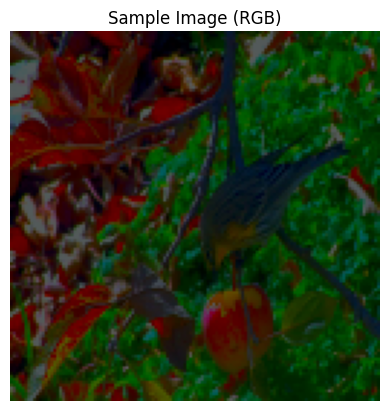


VALIDATION SET:
Shape: (5000, 128, 128, 3)
Data type: float16
Sample ranges - L: [0.004, 0.988]
Sample ranges - A: [-0.180, 0.555]
Sample ranges - B: [-0.320, 0.414]


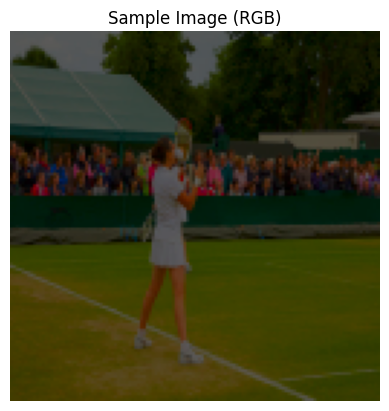


TEST SET:
Shape: (40670, 128, 128, 3)
Data type: float16
Sample ranges - L: [0.020, 1.000]
Sample ranges - A: [-0.172, 0.508]
Sample ranges - B: [-0.281, 0.305]


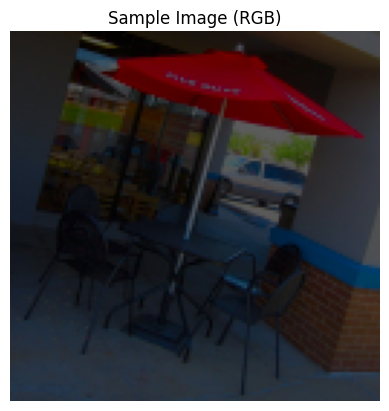

In [16]:
#Check just one file quickly
def quick_check(file_path):
    with h5py.File(file_path, 'r') as f:
        images = f['images']
        print(f"Shape: {images.shape}")
        print(f"Data type: {images.dtype}")

        # Check one image
        sample = images[0]
        print(f"Sample ranges - L: [{sample[...,0].min():.3f}, {sample[...,0].max():.3f}]")
        print(f"Sample ranges - A: [{sample[...,1].min():.3f}, {sample[...,1].max():.3f}]")
        print(f"Sample ranges - B: [{sample[...,2].min():.3f}, {sample[...,2].max():.3f}]")

        # Convert and display one image
        lab_denorm = sample.astype(np.float32)
        lab_denorm[..., 0] = lab_denorm[..., 0] * 100.0
        lab_denorm[..., 1] = lab_denorm[..., 1] * 128.0 + 128.0
        lab_denorm[..., 2] = lab_denorm[..., 2] * 128.0 + 128.0
        lab_uint8 = np.clip(lab_denorm, 0, 255).astype(np.uint8)
        rgb = cv2.cvtColor(lab_uint8, cv2.COLOR_LAB2RGB)

        plt.imshow(rgb)
        plt.title("Sample Image (RGB)")
        plt.axis('off')
        plt.show()

# Check each file
print("TRAINING SET:")
quick_check('/content/drive/MyDrive/Preprocessed_data_Image_colorizer/train.h5')

print("\nVALIDATION SET:")
quick_check('/content/drive/MyDrive/Preprocessed_data_Image_colorizer/val.h5')

print("\nTEST SET:")
quick_check('/content/drive/MyDrive/Preprocessed_data_Image_colorizer/test.h5')